In [1]:
import requests
from requests_oauthlib import OAuth2Session
from IPython.display import display, HTML
import urllib3
import os
import json
import config
import pandas as pd
from datetime import datetime
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium

#from urllib.parse import urlparse, parse_qs

/Users/anthonydillon/Projects/strava/strava-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Disable SSL verification warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Allow OAuth over HTTP for local testing (NOT recommended for production)
os.environ['OAUTHLIB_INSECURE_TRANSPORT'] = '1'

# Strava API endpoints
AUTH_URL = "https://www.strava.com/oauth/authorize"
TOKEN_URL = "https://www.strava.com/oauth/token"

# Your app's Strava API details
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
REDIRECT_URI = 'http://localhost:8000'  # This can be any valid URL for local testing

# Scope for the API access
SCOPE = ["activity:read_all"]

def get_oauth_session():
    return OAuth2Session(CLIENT_ID, redirect_uri=REDIRECT_URI, scope=SCOPE)

def main():
    print("Strava Integration App")
    
    oauth = get_oauth_session()
    authorization_url, _ = oauth.authorization_url(AUTH_URL)
    
    print("Connect to Strava to authorize access to your data.")
    display(HTML(f'<a href="{authorization_url}" target="_blank">Click here to connect to Strava</a>'))
    
    # Wait for the user to authorize and get the redirect URL
    redirect_response = input("Paste the full redirect URL here: ")
    
    # Extract the authorization code from the redirect URL
    from urllib.parse import urlparse, parse_qs
    parsed_url = urlparse(redirect_response)
    authorization_code = parse_qs(parsed_url.query)['code'][0]
    
    # Fetch the access token
    try:
        token_response = requests.post(
            TOKEN_URL,
            data={
                'client_id': CLIENT_ID,
                'client_secret': CLIENT_SECRET,
                'code': authorization_code,
                'grant_type': 'authorization_code'
            }
        )
        token_response.raise_for_status()  # Raise an exception for bad responses
        token = token_response.json()
        
        print("Token response:", json.dumps(token, indent=2))
        
        access_token = token['access_token']
        print("Successfully connected to Strava!")
        
        # Make an API call to Strava using the access token
        headers = {'Authorization': f"Bearer {access_token}"}
        response = requests.get("https://www.strava.com/api/v3/athlete", headers=headers)
        if response.status_code == 200:
            athlete = response.json()
            print(f"Welcome, {athlete['firstname']} {athlete['lastname']}!")
        else:
            print("Failed to fetch athlete data.")
            print("Response:", response.text)
        
        return access_token  # Return the access token for further use in the notebook
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Token response:", token_response.text)
        return None

# Run the main function
access_token = main()

Strava Integration App
Connect to Strava to authorize access to your data.


Paste the full redirect URL here:  http://localhost:8000/?state=nWknVlT74Y5GzDgyQjY8FEjMbClrni&code=6f5eaea9c3df637c83540ed6862373a3b85058d3&scope=read,activity:read_all


Token response: {
  "token_type": "Bearer",
  "expires_at": 1721076435,
  "expires_in": 8421,
  "refresh_token": "91b4376150defbd773e595fee71ce1731b75817f",
  "access_token": "8d166bf7e89a3a1c06862b4046c4b9b4c145ee40",
  "athlete": {
    "id": 58588489,
    "username": null,
    "resource_state": 2,
    "firstname": "Anthony",
    "lastname": "Dillon",
    "bio": "",
    "city": "Berlin",
    "state": "",
    "country": null,
    "sex": "M",
    "premium": true,
    "summit": true,
    "created_at": "2020-05-17T16:59:29Z",
    "updated_at": "2024-07-15T17:55:51Z",
    "badge_type_id": 1,
    "weight": 72.0,
    "profile_medium": "https://dgalywyr863hv.cloudfront.net/pictures/athletes/58588489/17809023/2/medium.jpg",
    "profile": "https://dgalywyr863hv.cloudfront.net/pictures/athletes/58588489/17809023/2/large.jpg",
    "friend": null,
    "follower": null
  }
}
Successfully connected to Strava!
Welcome, Anthony Dillon!


In [3]:
print(access_token)

8d166bf7e89a3a1c06862b4046c4b9b4c145ee40


In [4]:
def get_strava_activities(access_token):
    activities = []
    page = 1
    while True:
        url = f"https://www.strava.com/api/v3/athlete/activities"
        headers = {'Authorization': f'Bearer {access_token}'}
        params = {'per_page': 200, 'page': page}
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code != 200:
            print("Failed to retrieve activities:", response.content)
            break
        
        data = response.json()
        
        if not data:
            break
        
        activities.extend(data)
        page += 1
    
    return activities

def get_strava_streams(access_token, activity_id, keys):
    max_retries = 5  # Number of retries for rate limiting
    retry_delay = 60  # Delay in seconds between retries

    url = f"https://www.strava.com/api/v3/activities/{activity_id}/streams"
    headers = {'Authorization': f'Bearer {access_token}'}
    params = {
        'keys': keys,
        'key_by_type': 'true'
    }

    while True:
        response = requests.get(url, headers=headers, params=params)

        if response.status_code == 429:  # Rate limit exceeded
            print("Rate limit exceeded. Retrying...")
            max_retries -= 1
            if max_retries == 0:
                print("Max retries reached. Exiting.")
                break
            time.sleep(retry_delay)
            continue
        
        if response.status_code != 200:
            print("Failed to retrieve activities:", response.content)
            break

        data = response.json()

        if not data:
            break

        if keys not in data:
            print(f"{keys} stream not available.")
            return None

        return data[keys]['data']

def get_multiple_streams(access_token, activity_ids, keys):
    streams = []
    for activity_id in activity_ids:
        stream = get_strava_streams(access_token, activity_id, keys)#[keys]['data']
        streams.append(stream)

    return streams



def plot_heatmap(coordinates_list):
    tiles = 'https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png'
    attr = '&copy; <a href="https://www.stadiamaps.com/" target="_blank">Stadia Maps</a> &copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
    m = folium.Map(location=(52.5740, 13.4101), tiles=tiles, attr=attr)
    for coordinates in coordinates_list:
        if coordinates != None:
            folium.PolyLine(coordinates, color='#EB33FF', weight=2, opacity=0.6).add_to(m)
    return m


def format_dataframe(df):
    df = df.copy()

    # Format distance, speed and duration measurements.
    df.distance = df.distance / 1000
    df.average_speed = df.average_speed * 3600 / 1000
    df.max_speed = df.max_speed * 3600 / 1000
    df.moving_time = df.moving_time / 3600
    df.elapsed_time = df.elapsed_time / 3600

    # Format date / time columns.
    df['date'] = pd.to_datetime(df['start_date_local']).dt.strftime('%Y-%m-%d')
    
    return df

def get_ftp(date):
    ftp_changes = {
        '2021-10-25': 211,
        '2022-01-30': 237,
        '2022-12-17': 249,
        '2023-03-25': 265,
        '2023-10-05': 256,
        '2023-11-22': 262,
        '2024-02-14': 266,
        '2024-03-13': 272,
        '2024-04-15': 277,
        '2024-06-27': 279,
    }
    
    if isinstance(date, str):
        date = datetime.strptime(date, '%Y-%m-%d')
    elif isinstance(date, pd.Timestamp):
        date = date.to_pydatetime()
    
    sorted_dates = sorted(ftp_changes.keys())
    
    for i, change_date in enumerate(sorted_dates):
        change_date = datetime.strptime(change_date, '%Y-%m-%d')
        
        if date < change_date:
            if i == 0:
                return ftp_changes[sorted_dates[0]]
            return ftp_changes[sorted_dates[i-1]]
        
        if i == len(sorted_dates) - 1 or date < datetime.strptime(sorted_dates[i+1], '%Y-%m-%d'):
            return ftp_changes[sorted_dates[i]]
    
    return None  # This should never be reached if the input is valid


def ftp_if_tss(df):
    df = df.copy()
    df['ftp'] = df['date'].apply(get_ftp)
    df['intensity_factor'] = df.weighted_average_watts / df.ftp
    df['tss'] = (((df.moving_time * 3600) * df.weighted_average_watts * df.intensity_factor) / (df.ftp * 3600)) * 100
    return df


def resample_activities(df, cols_to_resample, agg='sum', period='D'):
    df = df.copy()
    
    existing_cols = df.columns
    cols = []

    for col in existing_cols:
        if col in cols_to_resample:
            cols.append(col)
    
    df = df.groupby(by='date')[cols].agg(agg).sort_index()
    df.index = pd.to_datetime(df.index)
    df = df.resample(period).agg(agg).fillna(0) # For weekly resampling this uses the label='right' argument by default
    return df


def ctl_atl_tsb(df):
    df = df.copy()
    df['chronic_training_load'] = df.tss.rolling(window=42).sum() / 42
    df['acute_training_load'] = df.tss.rolling(window=7).sum() / 7
    df['training_stress_balance'] = df.chronic_training_load - df.acute_training_load
    return df


def training_load_plot(df):
    # Create a subplot figure with 2 rows, 1 column, shared x-axes, and custom titles
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                        row_heights=[0.3, 0.3, 0.4])
    
    
    # Create traces for each data series
    traces = [
        go.Bar(x=df.index, y=df['tss'], name='TSS', visible=True),
        go.Scatter(x=df.index, y=df['chronic_training_load'], name='Chronic Training Load', visible=True),
        go.Scatter(x=df.index, y=df['acute_training_load'], name='Acute Training Load', visible=True),
        go.Scatter(x=df.index, y=df['training_stress_balance'], name='Training Stress Balance', visible=True)
    ]
    
    # Add traces to the appropriate subplots
    fig.add_trace(traces[0], row=1, col=1)  # TSS bar chart
    fig.add_trace(traces[1], row=2, col=1)  # Chronic Training Load line
    fig.add_trace(traces[2], row=2, col=1)  # Acute Training Load line
    fig.add_trace(traces[3], row=3, col=1)  # Training Stress Balance line
    
    # Update the layout of the figure
    fig.update_layout(
        xaxis3=dict(  # Configure the x-axis for the second subplot
            rangeselector=dict(  # Add buttons for quick date range selection
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ]),
                x=0.0, y=-0.2, xanchor='left', yanchor='top'
            ),
            rangeslider=dict(visible=True, thickness=0.05),  # Hide the range slider
            type="date"  # Set the axis type to date
        ),
        autosize=False,  # Disable auto-sizing
        height=800,  # Set the height of the figure
        width=1100  # Set the width of the figure
    )

    # ['top left', 'top center', 'top right', 'middle left', 'middle center', 'middle right', 'bottom left', 'bottom center', 'bottom right', 'start', 'middle', 'end']
    
    fig.add_hrect(y0=5, y1=20, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="blue", opacity=0.3, label=dict(text='hello', textposition='middle right')) # Fresh
    fig.add_hrect(y0=-10, y1=5, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="grey", opacity=0.3) # Grey zone    
    fig.add_hrect(y0=-10, y1=-30, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="green", opacity=0.4) # Optimal
    fig.add_hrect(y0=-100, y1=-30, row=3, col=1, exclude_empty_subplots=True, annotation=None, line_width=0, fillcolor="red", opacity=0.3) # High risk
    
    # Return the figure
    return fig


def make_metrics_plot(df):
    fig = make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing=0.05,
                            row_heights=[0.2, 0.2, 0.2, 0.2, 0.2])
    
    traces = [
        go.Scatter(x=monthly.index, y=monthly.average_watts, name='Average Power', visible=True),
        go.Scatter(x=monthly.index, y=monthly.weighted_average_watts, name='Weighted Average Power', visible=True),
        go.Scatter(x=monthly.index, y=monthly.average_cadence, name='Average Cadence'),
        go.Scatter(x=monthly.index, y=monthly.average_speed, name='Average Speed'),
        go.Scatter(x=monthly.index, y=monthly.average_heartrate, name='Average Heartrate'),
        go.Scatter(x=monthly.index, y=monthly.max_heartrate, name='Average Max. Heartrate')
    ]
    
    fig.add_trace(traces[0], row=1, col=1)
    fig.add_trace(traces[1], row=1, col=1)
    fig.add_trace(traces[2], row=2, col=1)
    fig.add_trace(traces[3], row=3, col=1)
    fig.add_trace(traces[4], row=4, col=1)
    fig.add_trace(traces[5], row=5, col=1)
    
    fig.update_layout(
            xaxis5=dict(  # Configure the x-axis for the second subplot
                rangeselector=dict(  # Add buttons for quick date range selection
                    buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(step="all")
                    ]),
                    x=0.0, y=-0.2, xanchor='left', yanchor='top'
                ),
                rangeslider=dict(visible=True, thickness=0.05),  # Hide the range slider
                type="date"  # Set the axis type to date
            ),
            autosize=False,  # Disable auto-sizing
            height=800,  # Set the height of the figure
            width=1100  # Set the width of the figure
        )
    
    return fig


In [5]:
activities = get_strava_activities(access_token)

In [13]:
df = pd.DataFrame(activities)
display(df.sport_type.unique())
display(df.type.unique())
df = df[(df.sport_type == 'Ride') | (df.sport_type == 'VirtualRide') | (df.sport_type == 'MountainBikeRide')]
df = format_dataframe(df)
df = ftp_if_tss(df)
df.to_csv('../data/clean/activities.csv')

array(['Hike', 'Ride', 'Swim', 'VirtualRide', 'MountainBikeRide', 'Run',
       'WeightTraining', 'Yoga', 'Walk'], dtype=object)

array(['Hike', 'Ride', 'Swim', 'VirtualRide', 'Run', 'WeightTraining',
       'Yoga', 'Walk'], dtype=object)

In [14]:
df.sport_type.unique()

array(['Ride', 'VirtualRide', 'MountainBikeRide'], dtype=object)

In [15]:
runs = df[(df.type == 'Run')|(df.type == 'VirtualRun')]
rides = df[(df.type == 'Ride')|(df.type == 'VirtualRide')]
rides

resource_state                                athlete            name  \
6                 2  {'id': 58588489, 'resource_state': 1}         Cycling   
7                 2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
8                 2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
9                 2  {'id': 58588489, 'resource_state': 1}         Cycling   
10                2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
..              ...                                    ...             ...   
565               2  {'id': 58588489, 'resource_state': 1}  Leisure cruise   
566               2  {'id': 58588489, 'resource_state': 1}    Morning Ride   
567               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
568               2  {'id': 58588489, 'resource_state': 1}  Afternoon Ride   
569               2  {'id': 58588489, 'resource_state': 1}    Morning Ride   

     distance  moving_time  elapsed_time  total_elevation_gain  type  \
6     91.4089     3.515000      4.345833                 168.0  Ride   
7     70.5743     2.558333      2.683611                 155.0  Ride   
8     29.9175     1.464722      1.591667                  37.0  Ride   
9     94.7840     3.802222      4.580278                 200.0  Ride   
10    44.5838     1.622500      2.005278                  53.0  Ride   
..        ...          ...           ...                   ...   ...   
565   59.1415     3.306944      4.291944                 183.9  Ride   
566   56.2561     2.788611      3.116389                 206.4  Ride   
567   20.3533     0.996667      1.143889                  58.2  Ride   
568   23.4551     1.254167      1.498611                  47.9  Ride   
569   31.6086     1.378889      1.378889                 115.0  Ride   

    sport_type           id  ... workout_type average_watts max_watts  \
6         Ride  11846286981  ...          NaN         164.3     474.0   
7         Ride  11838209790  ...          NaN         198.3     672.0   
8         Ride  11830945924  ...          NaN         111.1     331.0   
9         Ride  11823073868  ...          NaN         169.7     512.0   
10        Ride  11814843932  ...          NaN         208.5     561.0   
..         ...          ...  ...          ...           ...       ...   
565       Ride   4237379236  ...         10.0           NaN       NaN   
566       Ride   4210097961  ...         10.0           NaN       NaN   
567       Ride   4181429942  ...         10.0           NaN       NaN   
568       Ride   4153071546  ...          NaN           NaN       NaN   
569       Ride   4143862692  ...         10.0           NaN       NaN   

     weighted_average_watts kilojoules device_watts        date  ftp  \
6                     167.0     2078.5         True  2024-07-09  279   
7                     204.0     1826.7         True  2024-07-08  279   
8                     118.0      585.6         True  2024-07-07  279   
9                     176.0     2323.4         True  2024-07-06  279   
10                    212.0     1218.1         True  2024-07-05  279   
..                      ...        ...          ...         ...  ...   
565                     NaN        NaN        False  2020-10-24  211   
566                     NaN        NaN        False  2020-10-18  211   
567                     NaN        NaN        False  2020-10-11  211   
568                     NaN        NaN        False  2020-10-04  211   
569                     NaN        NaN        False  2020-10-03  211   

     intensity_factor         tss  
6            0.598566  125.935991  
7            0.731183  136.775735  
8            0.422939   26.200578  
9            0.630824  151.305399  
10           0.759857   93.680246  
..                ...         ...  
565               NaN         NaN  
566               NaN         NaN  
567               NaN         NaN  
568               NaN         NaN  
569               NaN         NaN  

[488 rows x 61 columns]

In [7]:
sum_cols = ['distance', 'moving_time', 'total_elevation_gain', 'kilojoules', 'suffer_score', 'tss']
mean_cols = ['average_watts', 'weighted_average_watts', 'average_cadence', 'average_heartrate', 'max_heartrate', 'average_speed', 'max_speed']
load_cols = ['chronic_training_load', 'acute_training_load', 'training_stress_balance']

In [8]:
daily_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='D')
daily_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='D')
daily_sum_with_load = ctl_atl_tsb(daily_sum).fillna(0)
daily = pd.concat([daily_sum_with_load, daily_mean], axis=1)


weekly_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='W')
weekly_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='W')
daily_load = daily[load_cols]
weekly_load = resample_activities(daily_load, cols_to_resample=load_cols, agg='mean', period='W')
weekly = pd.concat([weekly_sum, weekly_load, weekly_mean], axis=1)


monthly_mean = resample_activities(df, cols_to_resample=mean_cols, agg='mean', period='ME')
monthly_sum = resample_activities(df, cols_to_resample=sum_cols, agg='sum', period='ME')
monthly = pd.concat([monthly_mean, monthly_sum], axis=1)

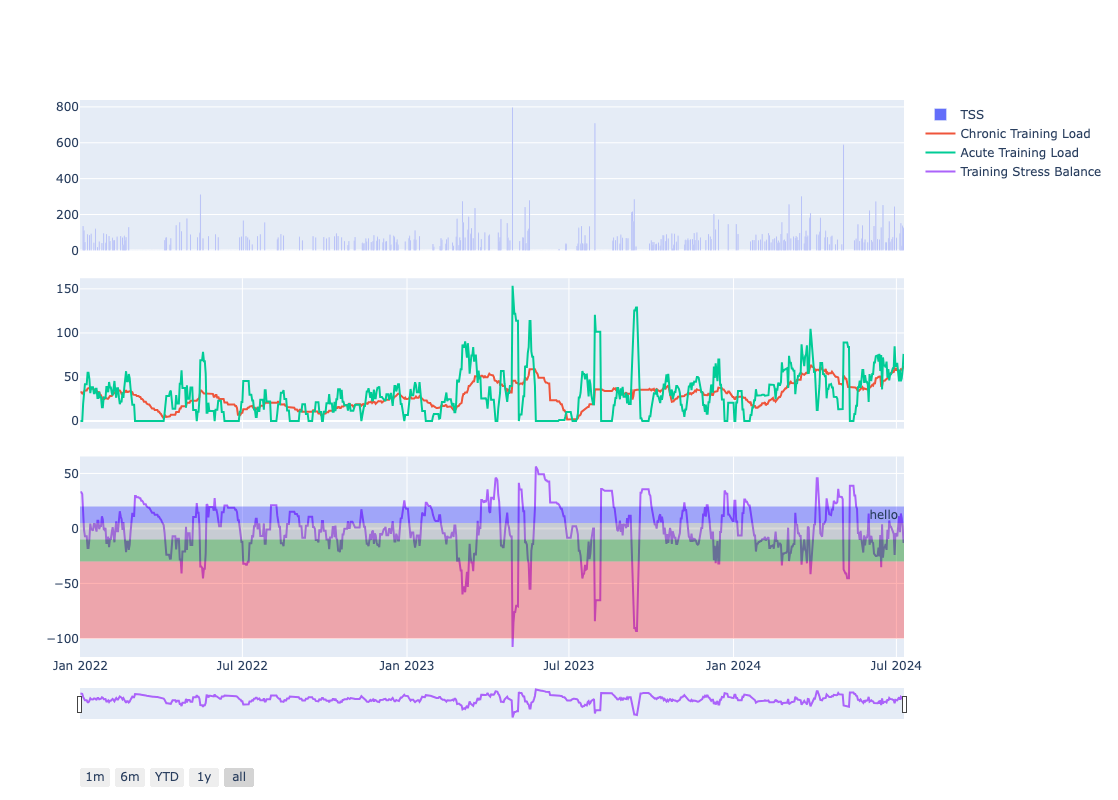

In [9]:
daily = daily[daily.index >= '2022-01-01']
training_load_plot(daily)

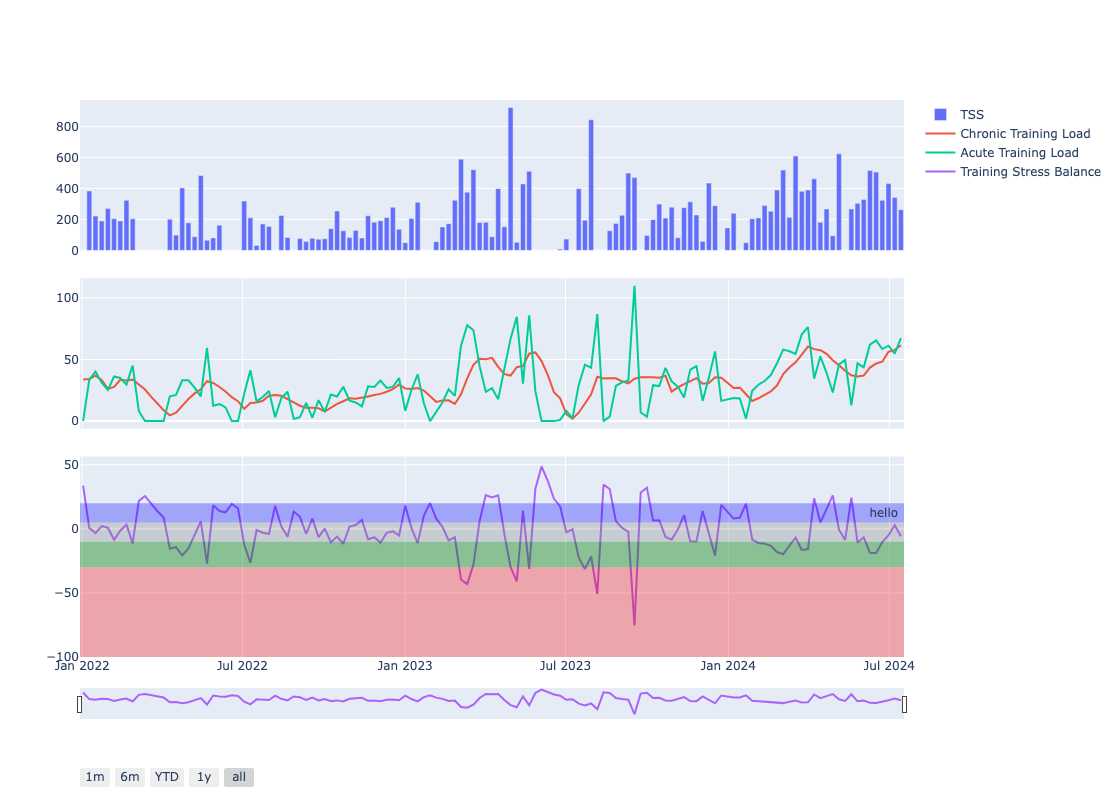

In [10]:
weekly = weekly[weekly.index >= '2022-01-01']
training_load_plot(weekly)

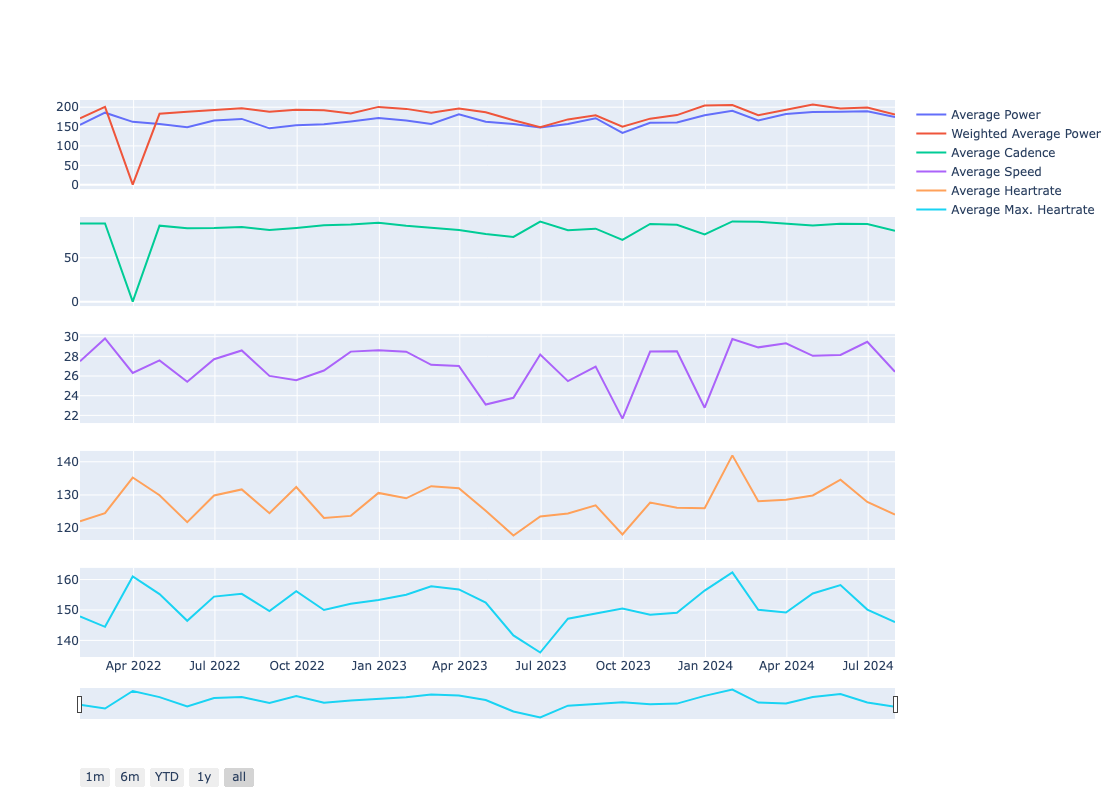

In [11]:
monthly = monthly[monthly.index >= '2022-01-01']
make_metrics_plot(monthly)

In [12]:
keys = 'latlng'
activity_ids = df.id[:10]
streams = get_multiple_streams(access_token, activity_ids, keys)

latlng stream not available.
latlng stream not available.


In [16]:
streams

[[[52.573605, 13.410193],
  [52.573639, 13.410183],
  [52.573685, 13.410169],
  [52.57373, 13.410151],
  [52.57378, 13.410131],
  [52.573833, 13.410109],
  [52.573879, 13.410087],
  [52.573929, 13.410067],
  [52.573975, 13.410042],
  [52.574017, 13.410015],
  [52.574059, 13.409989],
  [52.574104, 13.40997],
  [52.574146, 13.409957],
  [52.574184, 13.40994],
  [52.574223, 13.409917],
  [52.574264, 13.40989],
  [52.57431, 13.409861],
  [52.57436, 13.409838],
  [52.574406, 13.409824],
  [52.574451, 13.409809],
  [52.574497, 13.409785],
  [52.574543, 13.40975],
  [52.574585, 13.409698],
  [52.574623, 13.409642],
  [52.574657, 13.409576],
  [52.57468, 13.409497],
  [52.57468, 13.409431],
  [52.574673, 13.409375],
  [52.57465, 13.409322],
  [52.574627, 13.409267],
  [52.574608, 13.409218],
  [52.574593, 13.409164],
  [52.574585, 13.409105],
  [52.574574, 13.409045],
  [52.574554, 13.408983],
  [52.574532, 13.408915],
  [52.574512, 13.40884],
  [52.574493, 13.408766],
  [52.574474, 13.40869],

In [13]:
plot_heatmap(streams)